<a href="https://colab.research.google.com/github/Giogia/Scene-Reconstruction/blob/master/tsdf_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install OpenEXR

  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp36-cp36m-linux_x86_64.whl size=188436 sha256=43d615212bde6693e91bc0fc88e3e4058ea3a9dcc68e48aa9b452b6e7cf0981e
  Stored in directory: /root/.cache/pip/wheels/41/06/9f/c7dc838815b0e7dfc7d7dc19cc3d677edb47594d8489adc62a
Successfully built OpenEXR


In [0]:
import numpy as np
import time
import os
import csv

from numba import njit, prange
from skimage import measure
from PIL import Image
from google.colab import files

%matplotlib inline 
from matplotlib import pyplot as plt

try:
    import pycuda.driver as cuda
    import pycuda.autoinit
    from pycuda.compiler import SourceModule
    FUSION_GPU_MODE = 1

except Exception as err:
    print('Warning: {}'.format(err))
    print('Failed to import PyCUDA. Running fusion in CPU mode.')
    FUSION_GPU_MODE = 0

In [0]:
from ast import literal_eval

def read_csv(file, field, row_number=0):
    reader = csv.DictReader(open(file))
    row = list(reader)[row_number]

    return literal_eval(row[field])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


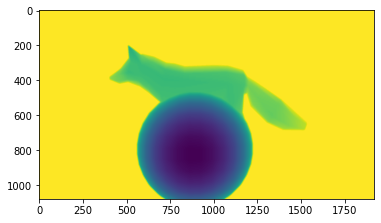

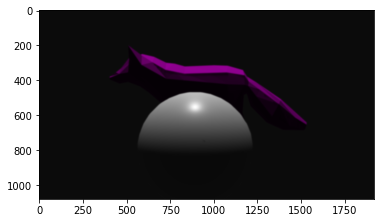

In [98]:
from OpenEXR import InputFile
from Imath import PixelType

def exr_to_color(path):
    file = InputFile(path)
    window = file.header()['dataWindow']
    channels = ('R', 'G', 'B')

    size = (window.max.y - window.min.y + 1, window.max.x - window.min.x + 1)

    channels_tuple = [np.frombuffer(channel, dtype=np.float32)
                      for channel in file.channels(channels, PixelType(PixelType.FLOAT))]
    exr_array = np.dstack(channels_tuple)

    return exr_array.reshape(size + (len(channels_tuple),))


def exr_to_depth(path, background=True):
    file = InputFile(path)
    window = file.header()['dataWindow']
    size = (window.max.y - window.min.y + 1, window.max.x - window.min.x + 1)

    exr_depth = file.channel('Z', PixelType(PixelType.FLOAT))
    exr_depth = np.fromstring(exr_depth, dtype=np.float32)

    # filter out background
    threshold = np.unique(exr_depth)[-2]
    exr_depth[exr_depth > threshold] = threshold if background else 0

    return np.reshape(exr_depth, size)

def show_array(data):

    data /= np.max(data)
    plt.imshow(data, interpolation='bicubic')
    plt.show()

In [0]:
class TSDFVolume:
    """Volumetric TSDF Fusion of RGB-D Images.
  """

    def __init__(self, vol_bnds, voxel_size, use_gpu=True):
        """Constructor.

    Args:
      vol_bnds (ndarray): An ndarray of shape (3, 2). Specifies the
        xyz bounds (min/max) in meters.
      voxel_size (float): The volume discretization in meters.
    """
        vol_bnds = np.asarray(vol_bnds)
        assert vol_bnds.shape == (3, 2), "[!] `vol_bnds` should be of shape (3, 2)."

        # Define voxel volume parameters
        self._vol_bnds = vol_bnds
        self._voxel_size = float(voxel_size)
        self._trunc_margin = 5 * self._voxel_size  # truncation on SDF
        self._color_const = 256 * 256

        # Adjust volume bounds and ensure C-order contiguous
        self._vol_dim = np.ceil((self._vol_bnds[:, 1] - self._vol_bnds[:, 0]) / self._voxel_size).copy(
            order='C').astype(int)
        self._vol_bnds[:, 1] = self._vol_bnds[:, 0] + self._vol_dim * self._voxel_size
        self._vol_origin = self._vol_bnds[:, 0].copy(order='C').astype(np.float32)

        print("Voxel volume size: {} x {} x {} - # points: {:,}".format(
            self._vol_dim[0], self._vol_dim[1], self._vol_dim[2],
            self._vol_dim[0] * self._vol_dim[1] * self._vol_dim[2])
        )

        # Initialize pointers to voxel volume in CPU memory
        self._tsdf_vol_cpu = np.ones(self._vol_dim).astype(np.float32)
        # for computing the cumulative moving average of observations per voxel
        self._weight_vol_cpu = np.zeros(self._vol_dim).astype(np.float32)
        self._color_vol_cpu = np.zeros(self._vol_dim).astype(np.float32)

        self.gpu_mode = use_gpu and FUSION_GPU_MODE

        # Copy voxel volumes to GPU
        if self.gpu_mode:
            self._tsdf_vol_gpu = cuda.mem_alloc(self._tsdf_vol_cpu.nbytes)
            cuda.memcpy_htod(self._tsdf_vol_gpu, self._tsdf_vol_cpu)
            self._weight_vol_gpu = cuda.mem_alloc(self._weight_vol_cpu.nbytes)
            cuda.memcpy_htod(self._weight_vol_gpu, self._weight_vol_cpu)
            self._color_vol_gpu = cuda.mem_alloc(self._color_vol_cpu.nbytes)
            cuda.memcpy_htod(self._color_vol_gpu, self._color_vol_cpu)

            # Cuda kernel function (C++)
            self._cuda_src_mod = SourceModule("""
        __global__ void integrate(float * tsdf_vol,
                                  float * weight_vol,
                                  float * color_vol,
                                  float * vol_dim,
                                  float * vol_origin,
                                  float * cam_intr,
                                  float * cam_pose,
                                  float * other_params,
                                  float * color_im,
                                  float * depth_im) {
          // Get voxel index
          int gpu_loop_idx = (int) other_params[0];
          int max_threads_per_block = blockDim.x;
          int block_idx = blockIdx.z*gridDim.y*gridDim.x+blockIdx.y*gridDim.x+blockIdx.x;
          int voxel_idx = gpu_loop_idx*gridDim.x*gridDim.y*gridDim.z*max_threads_per_block+block_idx*max_threads_per_block+threadIdx.x;
          int vol_dim_x = (int) vol_dim[0];
          int vol_dim_y = (int) vol_dim[1];
          int vol_dim_z = (int) vol_dim[2];
          if (voxel_idx > vol_dim_x*vol_dim_y*vol_dim_z)
              return;
          // Get voxel grid coordinates (note: be careful when casting)
          float voxel_x = floorf(((float)voxel_idx)/((float)(vol_dim_y*vol_dim_z)));
          float voxel_y = floorf(((float)(voxel_idx-((int)voxel_x)*vol_dim_y*vol_dim_z))/((float)vol_dim_z));
          float voxel_z = (float)(voxel_idx-((int)voxel_x)*vol_dim_y*vol_dim_z-((int)voxel_y)*vol_dim_z);
          // Voxel grid coordinates to world coordinates
          float voxel_size = other_params[1];
          float pt_x = vol_origin[0]+voxel_x*voxel_size;
          float pt_y = vol_origin[1]+voxel_y*voxel_size;
          float pt_z = vol_origin[2]+voxel_z*voxel_size;
          // World coordinates to camera coordinates
          float tmp_pt_x = pt_x-cam_pose[0*4+3];
          float tmp_pt_y = pt_y-cam_pose[1*4+3];
          float tmp_pt_z = pt_z-cam_pose[2*4+3];
          float cam_pt_x = cam_pose[0*4+0]*tmp_pt_x+cam_pose[1*4+0]*tmp_pt_y+cam_pose[2*4+0]*tmp_pt_z;
          float cam_pt_y = cam_pose[0*4+1]*tmp_pt_x+cam_pose[1*4+1]*tmp_pt_y+cam_pose[2*4+1]*tmp_pt_z;
          float cam_pt_z = cam_pose[0*4+2]*tmp_pt_x+cam_pose[1*4+2]*tmp_pt_y+cam_pose[2*4+2]*tmp_pt_z;
          // Camera coordinates to image pixels
          int pixel_x = (int) roundf(cam_intr[0*3+0]*(cam_pt_x/cam_pt_z)+cam_intr[0*3+2]);
          int pixel_y = (int) roundf(cam_intr[1*3+1]*(cam_pt_y/cam_pt_z)+cam_intr[1*3+2]);
          // Skip if outside view frustum
          int im_h = (int) other_params[2];
          int im_w = (int) other_params[3];
          if (pixel_x < 0 || pixel_x >= im_w || pixel_y < 0 || pixel_y >= im_h || cam_pt_z<0)
              return;
          // Skip invalid depth
          float depth_value = depth_im[pixel_y*im_w+pixel_x];
          if (depth_value == 0)
              return;
          // Integrate TSDF
          float trunc_margin = other_params[4];
          float depth_diff = depth_value-cam_pt_z;
          if (depth_diff < -trunc_margin)
              return;
          float dist = fmin(1.0f,depth_diff/trunc_margin);
          float w_old = weight_vol[voxel_idx];
          float obs_weight = other_params[5];
          float w_new = w_old + obs_weight;
          weight_vol[voxel_idx] = w_new;
          tsdf_vol[voxel_idx] = (tsdf_vol[voxel_idx]*w_old+obs_weight*dist)/w_new;
          // Integrate color
          float old_color = color_vol[voxel_idx];
          float old_b = floorf(old_color/(256*256));
          float old_g = floorf((old_color-old_b*256*256)/256);
          float old_r = old_color-old_b*256*256-old_g*256;
          float new_color = color_im[pixel_y*im_w+pixel_x];
          float new_b = floorf(new_color/(256*256));
          float new_g = floorf((new_color-new_b*256*256)/256);
          float new_r = new_color-new_b*256*256-new_g*256;
          new_b = fmin(roundf((old_b*w_old+obs_weight*new_b)/w_new),255.0f);
          new_g = fmin(roundf((old_g*w_old+obs_weight*new_g)/w_new),255.0f);
          new_r = fmin(roundf((old_r*w_old+obs_weight*new_r)/w_new),255.0f);
          color_vol[voxel_idx] = new_b*256*256+new_g*256+new_r;
        }""")

            self._cuda_integrate = self._cuda_src_mod.get_function("integrate")

            # Determine block/grid size on GPU
            gpu_dev = cuda.Device(0)
            self._max_gpu_threads_per_block = gpu_dev.MAX_THREADS_PER_BLOCK
            n_blocks = int(np.ceil(float(np.prod(self._vol_dim)) / float(self._max_gpu_threads_per_block)))
            grid_dim_x = min(gpu_dev.MAX_GRID_DIM_X, int(np.floor(np.cbrt(n_blocks))))
            grid_dim_y = min(gpu_dev.MAX_GRID_DIM_Y, int(np.floor(np.sqrt(n_blocks / grid_dim_x))))
            grid_dim_z = min(gpu_dev.MAX_GRID_DIM_Z, int(np.ceil(float(n_blocks) / float(grid_dim_x * grid_dim_y))))
            self._max_gpu_grid_dim = np.array([grid_dim_x, grid_dim_y, grid_dim_z]).astype(int)
            self._n_gpu_loops = int(np.ceil(float(np.prod(self._vol_dim)) / float(
                np.prod(self._max_gpu_grid_dim) * self._max_gpu_threads_per_block)))

        else:
            # Get voxel grid coordinates
            xv, yv, zv = np.meshgrid(
                range(self._vol_dim[0]),
                range(self._vol_dim[1]),
                range(self._vol_dim[2]),
                indexing='ij'
            )
            self.vox_coords = np.concatenate([
                xv.reshape(1, -1),
                yv.reshape(1, -1),
                zv.reshape(1, -1)
            ], axis=0).astype(int).T

    @staticmethod
    @njit(parallel=True)
    def vox2world(vol_origin, vox_coords, vox_size):
        """Convert voxel grid coordinates to world coordinates.
    """
        vol_origin = vol_origin.astype(np.float32)
        vox_coords = vox_coords.astype(np.float32)
        cam_pts = np.empty_like(vox_coords, dtype=np.float32)
        for i in prange(vox_coords.shape[0]):
            for j in range(3):
                cam_pts[i, j] = vol_origin[j] + (vox_size * vox_coords[i, j])
        return cam_pts

    @staticmethod
    @njit(parallel=True)
    def cam2pix(cam_pts, intr):
        """Convert camera coordinates to pixel coordinates.
    """
        intr = intr.astype(np.float32)
        fx, fy = intr[0, 0], intr[1, 1]
        cx, cy = intr[0, 2], intr[1, 2]
        pix = np.empty((cam_pts.shape[0], 2), dtype=np.int64)
        for i in prange(cam_pts.shape[0]):
            pix[i, 0] = int(np.round((cam_pts[i, 0] * fx / cam_pts[i, 2]) + cx))
            pix[i, 1] = int(np.round((cam_pts[i, 1] * fy / cam_pts[i, 2]) + cy))
        return pix

    @staticmethod
    @njit(parallel=True)
    def integrate_tsdf(tsdf_vol, dist, w_old, obs_weight):
        """Integrate the TSDF volume.
    """
        tsdf_vol_int = np.empty_like(tsdf_vol, dtype=np.float32)
        w_new = np.empty_like(w_old, dtype=np.float32)
        for i in prange(len(tsdf_vol)):
            w_new[i] = w_old[i] + obs_weight
            tsdf_vol_int[i] = (w_old[i] * tsdf_vol[i] + obs_weight * dist[i]) / w_new[i]
        return tsdf_vol_int, w_new

    def integrate(self, color_im, depth_im, cam_intr, cam_pose, obs_weight=1.):
        """Integrate an RGB-D frame into the TSDF volume.

    Args:
      color_im (ndarray): An RGB image of shape (H, W, 3).
      depth_im (ndarray): A depth image of shape (H, W).
      cam_intr (ndarray): The camera intrinsics matrix of shape (3, 3).
      cam_pose (ndarray): The camera pose (i.e. extrinsics) of shape (4, 4).
      obs_weight (float): The weight to assign for the current observation. A higher
        value
    """
        im_h, im_w = depth_im.shape

        # Fold RGB color image into a single channel image
        color_im = color_im.astype(np.float32)
        color_im = np.floor(color_im[..., 2] * self._color_const + color_im[..., 1] * 256 + color_im[..., 0])

        if self.gpu_mode:  # GPU mode: integrate voxel volume (calls CUDA kernel)
            for gpu_loop_idx in range(self._n_gpu_loops):
                self._cuda_integrate(self._tsdf_vol_gpu,
                                     self._weight_vol_gpu,
                                     self._color_vol_gpu,
                                     cuda.InOut(self._vol_dim.astype(np.float32)),
                                     cuda.InOut(self._vol_origin.astype(np.float32)),
                                     cuda.InOut(cam_intr.reshape(-1).astype(np.float32)),
                                     cuda.InOut(cam_pose.reshape(-1).astype(np.float32)),
                                     cuda.InOut(np.asarray([
                                         gpu_loop_idx,
                                         self._voxel_size,
                                         im_h,
                                         im_w,
                                         self._trunc_margin,
                                         obs_weight
                                     ], np.float32)),
                                     cuda.InOut(color_im.reshape(-1).astype(np.float32)),
                                     cuda.InOut(depth_im.reshape(-1).astype(np.float32)),
                                     block=(self._max_gpu_threads_per_block, 1, 1),
                                     grid=(
                                         int(self._max_gpu_grid_dim[0]),
                                         int(self._max_gpu_grid_dim[1]),
                                         int(self._max_gpu_grid_dim[2]),
                                     )
                                     )
        else:  # CPU mode: integrate voxel volume (vectorized implementation)
            # Convert voxel grid coordinates to pixel coordinates
            cam_pts = self.vox2world(self._vol_origin, self.vox_coords, self._voxel_size)
            cam_pts = rigid_transform(cam_pts, np.linalg.inv(cam_pose))
            pix_z = cam_pts[:, 2]
            pix = self.cam2pix(cam_pts, cam_intr)
            pix_x, pix_y = pix[:, 0], pix[:, 1]

            # Eliminate pixels outside view frustum
            valid_pix = np.logical_and(pix_x >= 0,
                                       np.logical_and(pix_x < im_w,
                                                      np.logical_and(pix_y >= 0,
                                                                     np.logical_and(pix_y < im_h,
                                                                                    pix_z > 0))))
            depth_val = np.zeros(pix_x.shape)
            depth_val[valid_pix] = depth_im[pix_y[valid_pix], pix_x[valid_pix]]

            # Integrate TSDF
            depth_diff = depth_val - pix_z
            valid_pts = np.logical_and(depth_val > 0, depth_diff >= -self._trunc_margin)
            dist = np.minimum(1, depth_diff / self._trunc_margin)
            valid_vox_x = self.vox_coords[valid_pts, 0]
            valid_vox_y = self.vox_coords[valid_pts, 1]
            valid_vox_z = self.vox_coords[valid_pts, 2]
            w_old = self._weight_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z]
            tsdf_vals = self._tsdf_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z]
            valid_dist = dist[valid_pts]
            tsdf_vol_new, w_new = self.integrate_tsdf(tsdf_vals, valid_dist, w_old, obs_weight)
            self._weight_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z] = w_new
            self._tsdf_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z] = tsdf_vol_new

            # Integrate color
            old_color = self._color_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z]
            old_b = np.floor(old_color / self._color_const)
            old_g = np.floor((old_color - old_b * self._color_const) / 256)
            old_r = old_color - old_b * self._color_const - old_g * 256
            new_color = color_im[pix_y[valid_pts], pix_x[valid_pts]]
            new_b = np.floor(new_color / self._color_const)
            new_g = np.floor((new_color - new_b * self._color_const) / 256)
            new_r = new_color - new_b * self._color_const - new_g * 256
            new_b = np.minimum(255., np.round((w_old * old_b + obs_weight * new_b) / w_new))
            new_g = np.minimum(255., np.round((w_old * old_g + obs_weight * new_g) / w_new))
            new_r = np.minimum(255., np.round((w_old * old_r + obs_weight * new_r) / w_new))
            self._color_vol_cpu[valid_vox_x, valid_vox_y, valid_vox_z] = new_b * self._color_const + new_g * 256 + new_r

    def get_volume(self):
        if self.gpu_mode:
            cuda.memcpy_dtoh(self._tsdf_vol_cpu, self._tsdf_vol_gpu)
            cuda.memcpy_dtoh(self._color_vol_cpu, self._color_vol_gpu)
        return self._tsdf_vol_cpu, self._color_vol_cpu

    def get_point_cloud(self):
        """Extract a point cloud from the voxel volume.
    """
        tsdf_vol, color_vol = self.get_volume()

        # Marching cubes
        verts = measure.marching_cubes_lewiner(tsdf_vol, level=0)[0]
        verts_ind = np.round(verts).astype(int)
        verts = verts * self._voxel_size + self._vol_origin

        # Get vertex colors
        rgb_vals = color_vol[verts_ind[:, 0], verts_ind[:, 1], verts_ind[:, 2]]
        colors_b = np.floor(rgb_vals / self._color_const)
        colors_g = np.floor((rgb_vals - colors_b * self._color_const) / 256)
        colors_r = rgb_vals - colors_b * self._color_const - colors_g * 256
        colors = np.floor(np.asarray([colors_r, colors_g, colors_b])).T
        colors = colors.astype(np.uint8)

        pc = np.hstack([verts, colors])
        return pc

    def get_mesh(self):
        """Compute a mesh from the voxel volume using marching cubes.
    """
        tsdf_vol, color_vol = self.get_volume()

        # Marching cubes
        verts, faces, norms, vals = measure.marching_cubes_lewiner(tsdf_vol, level=0)
        verts_ind = np.round(verts).astype(int)
        verts = verts * self._voxel_size + self._vol_origin  # voxel grid coordinates to world coordinates

        # Get vertex colors
        rgb_vals = color_vol[verts_ind[:, 0], verts_ind[:, 1], verts_ind[:, 2]]
        colors_b = np.floor(rgb_vals / self._color_const)
        colors_g = np.floor((rgb_vals - colors_b * self._color_const) / 256)
        colors_r = rgb_vals - colors_b * self._color_const - colors_g * 256
        colors = np.floor(np.asarray([colors_r, colors_g, colors_b])).T
        colors = colors.astype(np.uint8)
        return verts, faces, norms, colors


def rigid_transform(xyz, transform):
    """Applies a rigid transform to an (N, 3) pointcloud.
  """
    xyz_h = np.hstack([xyz, np.ones((len(xyz), 1), dtype=np.float32)])
    xyz_t_h = np.dot(transform, xyz_h.T).T
    return xyz_t_h[:, :3]


def get_view_frustum(depth_im, cam_intr, cam_pose):
    """Get corners of 3D camera view frustum of depth image
  """
    im_h = depth_im.shape[0]
    im_w = depth_im.shape[1]
    max_depth = np.max(depth_im)
    view_frust_pts = np.array([
        (np.array([0, 0, 0, im_w, im_w]) - cam_intr[0, 2]) * np.array([0, max_depth, max_depth, max_depth, max_depth]) /
        cam_intr[0, 0],
        (np.array([0, 0, im_h, 0, im_h]) - cam_intr[1, 2]) * np.array([0, max_depth, max_depth, max_depth, max_depth]) /
        cam_intr[1, 1],
        np.array([0, max_depth, max_depth, max_depth, max_depth])
    ])
    view_frust_pts = rigid_transform(view_frust_pts.T, cam_pose).T
    return view_frust_pts


def meshwrite(filename, verts, faces, norms, colors):
    """Save a 3D mesh to a polygon .ply file.
  """
    # Write header
    ply_file = open(filename, 'w')
    ply_file.write("ply\n")
    ply_file.write("format ascii 1.0\n")
    ply_file.write("element vertex %d\n" % (verts.shape[0]))
    ply_file.write("property float x\n")
    ply_file.write("property float y\n")
    ply_file.write("property float z\n")
    ply_file.write("property float nx\n")
    ply_file.write("property float ny\n")
    ply_file.write("property float nz\n")
    ply_file.write("property uchar red\n")
    ply_file.write("property uchar green\n")
    ply_file.write("property uchar blue\n")
    ply_file.write("element face %d\n" % (faces.shape[0]))
    ply_file.write("property list uchar int vertex_index\n")
    ply_file.write("end_header\n")

    # Write vertex list
    for i in range(verts.shape[0]):
        ply_file.write("%f %f %f %f %f %f %d %d %d\n" % (
            verts[i, 0], verts[i, 1], verts[i, 2],
            norms[i, 0], norms[i, 1], norms[i, 2],
            colors[i, 0], colors[i, 1], colors[i, 2],
        ))

    # Write face list
    for i in range(faces.shape[0]):
        ply_file.write("3 %d %d %d\n" % (faces[i, 0], faces[i, 1], faces[i, 2]))

    ply_file.close()


def pcwrite(filename, xyzrgb):
    """Save a point cloud to a polygon .ply file.
  """
    xyz = xyzrgb[:, :3]
    rgb = xyzrgb[:, 3:].astype(np.uint8)

    # Write header
    ply_file = open(filename, 'w')
    ply_file.write("ply\n")
    ply_file.write("format ascii 1.0\n")
    ply_file.write("element vertex %d\n" % (xyz.shape[0]))
    ply_file.write("property float x\n")
    ply_file.write("property float y\n")
    ply_file.write("property float z\n")
    ply_file.write("property uchar red\n")
    ply_file.write("property uchar green\n")
    ply_file.write("property uchar blue\n")
    ply_file.write("end_header\n")

    # Write vertex list
    for i in range(xyz.shape[0]):
        ply_file.write("%f %f %f %d %d %d\n" % (
            xyz[i, 0], xyz[i, 1], xyz[i, 2],
            rgb[i, 0], rgb[i, 1], rgb[i, 2],
        ))


In [0]:
def fuse(name):

    print("Estimating voxel volume bounds...")
    images = 1 #TEST_SAMPLES

    camera_intrinsics_file = os.path.join(PATH, '../test', name, 'camera_calibration.csv')
    camera_intrinsics = np.reshape(read_csv(file=camera_intrinsics_file, field='Camera Intrinsics'), (3, 3))

    bounds = np.zeros((3, 2))

    for i in range(0, images):

        path = os.path.join(PATH, '../test', name, str(i+1) + '.exr')
        depth = exr_to_depth(path, far_threshold=100)

        camera_pose_file = os.path.join(PATH, '../test', name, 'frames.csv')
        camera_pose = np.reshape(np.array(
            read_csv(file=camera_pose_file, field='Matrix', row_number=i), dtype=float), (4, 4))

        # Compute camera view frustum and extend convex hull
        view_frust_pts = fusion.get_view_frustum(depth, camera_intrinsics, camera_pose)
        bounds[:, 0] = np.minimum(bounds[:, 0], np.amin(view_frust_pts, axis=1))
        bounds[:, 1] = np.maximum(bounds[:, 1], np.amax(view_frust_pts, axis=1))

    print("Initializing voxel volume...")
    tsdf_vol = fusion.TSDFVolume(bounds, voxel_size=0.03)

    # Loop through RGB-D images and fuse them together
    t0_elapse = time.time()

    for i in range(0, images):
        print("Fusing frame %d/%d" % (i + 1, images))

        # Read RGB-D image and camera pose
        path = os.path.join(PATH, '../test', name, str(i + 1) + '.exr')
        color_image = exr_to_array(path)
        depth = exr_to_depth(path)

        camera_pose = np.reshape(np.array(
            read_csv(file=camera_pose_file, field='Matrix', row_number=i), dtype=float), (4, 4))

        # Integrate observation into voxel volume (assume color aligned with depth)
        tsdf_vol.integrate(color_image, depth, camera_intrinsics, camera_pose, obs_weight=1.)

    fps = images / (time.time() - t0_elapse)
    print("Average FPS: {:.2f}".format(fps))

    # Get mesh from voxel volume and save to disk (can be viewed with Meshlab)
    print("Saving mesh to mesh.ply...")
    verts, faces, norms, colors = tsdf_vol.get_mesh()

    saving_path = os.path.join(PATH, '../test', name, 'mesh.ply')
    fusion.meshwrite(saving_path, verts, faces, norms, colors)

    # Get point cloud from voxel volume and save to disk (can be viewed with Meshlab)
    # print("Saving point cloud to pc.ply...")
    # point_cloud = tsdf_vol.get_point_cloud()
    # fusion.pcwrite("pc.ply", point_cloud)


fuse('Fox')
